In [2]:
import numpy as np
import glob
import json
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

# ML libraries
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from keras.losses import categorical_crossentropy

## On the full ('raw') images first; will try compressed & normalized images by Misha later

In [4]:
# Load dataset
building_directories = glob.glob("../../test/easy/*")[:2]

img_width = 512
img_height = 384
num_years = len(np.arange(2012,2018+1))

# We're going to be using gray scale, so last dimension is 1 rather than 3 for RGB
dataset = np.zeros( (len(building_directories), num_years, img_height, img_width, 1) )
#dataset = np.zeros( (len(building_directories), num_years, img_height, img_width, 3) )

print("Dataset consists of %d properties"%dataset.shape[0])

# For storing the true transition years labeled by Chris
true_transition_years = []
# For tracking the property location
building_addresses = []

# Loop over the properties
for d,directory in enumerate(building_directories):
    
    # Extract meta info
    with open(directory + "/metadata.json", "r") as read_file:
        data = json.load(read_file)
    building_addresses.append(data['address'])
    
    # Extract true transition year
    with open(directory + "/transition.txt", "r") as read_file:
        data = read_file.read()          
    true_transition_years.append(int(data))
    
    # Get the images
    for y in range(num_years):
        # Load image, convert to gray scale, discard alpha channel and normalize pixel values
        dataset[d,y] = np.array(Image.open(directory + "/%s.png"%(2012+y)).convert('LA'))[:,:,:1]/255
        #dataset[d,y] = np.array(Image.open(directory + "/%s.png"%(2012+y)))[:,:,:3]/255
        
        # Normalize images
        dataset[d,y] -= dataset[d,y].mean()
        dataset[d,y] /= dataset[d,y].std()

Dataset consists of 2 properties


### Define NN model

In [15]:
def init_NN():
    # Define a NN model
    model = Sequential()
    model.add(Conv2D(16, kernel_size=(5, 5), strides=(1, 1),
                     activation='relu',
                     input_shape=(img_height, img_width, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
   # model.add(Conv2D(64, (5, 5), activation='relu'))
   # model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(10, activation='relu'))
    model.add(Dense(2, activation='softmax'))

    model.compile(loss=categorical_crossentropy,
                  optimizer='adam',
                  metrics=['accuracy'])
    
    return model

### Naive confusion, per year and per building

In [16]:
np.random.seed(1990)
num_epochs = 10

# Keep track of the network's accuracy per epoch, per building and per 'guessed' transition year
network_performance_for_building = np.zeros( (dataset.shape[0], num_epochs, num_years))

# We know that at the edges, we'll have 100% performance; so we can skip those
for transition_year in range(1,num_years-1):
    print("Transition year %d"%(transition_year + 2012))
    
    # Create the labels
    labels = np.zeros( (num_years,2) )
    for y in range(num_years):
        labels[y] = [1,0] if y <= transition_year else [0,1]
        
    #
    # Could sample indices here instead of taking the entire dataset
    #
    building_indices = np.arange(dataset.shape[0])

    # New network for every building and every guessed transition year
    for b in building_indices:
        print("\t Considering property number %d out of %d"%(b, len(building_indices)))
        NN_model = init_NN()
    
        for e in np.arange(num_epochs):
            # Train the network with this set of labels
            history = NN_model.fit( dataset[b], labels, epochs=1, verbose=0 )
            network_performance_for_building[b,e,transition_year] = history.history['acc'][0]

Transition year 2013
	 Considering property number 0 out of 2
	 Considering property number 1 out of 2
Transition year 2014
	 Considering property number 0 out of 2
	 Considering property number 1 out of 2
Transition year 2015
	 Considering property number 0 out of 2
	 Considering property number 1 out of 2
Transition year 2016
	 Considering property number 0 out of 2
	 Considering property number 1 out of 2
Transition year 2017
	 Considering property number 0 out of 2
	 Considering property number 1 out of 2


True vs predicted:  2016 2014
True vs predicted:  2017 2016


[Text(0, 0, '2013'),
 Text(0, 0, '2014'),
 Text(0, 0, '2015'),
 Text(0, 0, '2016'),
 Text(0, 0, '2017')]

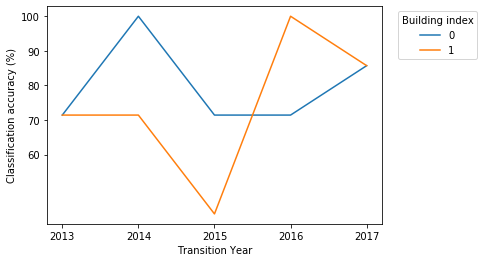

In [17]:
fig, ax = plt.subplots()

epoch_to_plot = 2

predicted_transition_years = []
for b in range(dataset.shape[0]):
    ax.plot( network_performance_for_building[b,epoch_to_plot][1:-1], label="%d"%b )
    
    transition_index = np.argmax(network_performance_for_building[b,epoch_to_plot])
    print("True vs predicted: ", true_transition_years[b], range(2012,2019)[transition_index])
    predicted_transition_years.append(range(2012,2019)[transition_index])
    
ax.legend(title="Building index", fancybox=True, shadow=False, bbox_to_anchor=(0.3, 1, 1, 0))

ax.set_ylabel("Classification accuracy (%)")
ax.set_yticks(np.arange(6,11)/10)
ax.set_yticklabels(np.arange(60,110, 10))

ax.set_xlabel("Transition Year")
ax.set_xticks( np.arange(5) )
ax.set_xticklabels( np.arange(2013,2018) )

## One network per year (generalize across buildings?)

In [79]:
np.random.seed(1990)
num_epochs = 10

network_performance_for_building = np.zeros( (dataset.shape[0], num_epochs, num_years))

for transition_year in range(1,num_years-1):
    print("Transition year %d"%(transition_year + 2012))
    
    # I want the model to generalize over all the buildings
    NN_model_for_this_year = init_NN()
    
    # Create the labels
    labels = np.zeros( (num_years,2) )
    for y in range(num_years):
        labels[y] = [1,0] if y <= transition_year else [0,1]

    for e in np.arange(num_epochs):
        print("Epoch: %d"%e)
    
        # Sample a few buildings
        building_indices = np.arange(dataset.shape[0]) #np.random.choice(dataset.shape[0], size=3, replace=False)
    
        # Pick a transition year for each
        for b in building_indices:
            # Train the network with this set of labels
            history = NN_model_for_this_year.fit( dataset[b], labels, epochs=1, verbose=0 )
            network_performance_for_building[b,e,transition_year] = history.history['acc'][0]

Transition year 2013
Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Transition year 2014
Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Transition year 2015
Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Transition year 2016
Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Transition year 2017
Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
